# Homework 2: Line Detection

## Problem 1: Preprocessing

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from util import ops
from util.keypoint_detection import HessianDetector

### Load Image Data

In [2]:
original_image = ops.load_image("./original-images/road.png")

Dimensions of ./original-images/road.png: 407 x 548


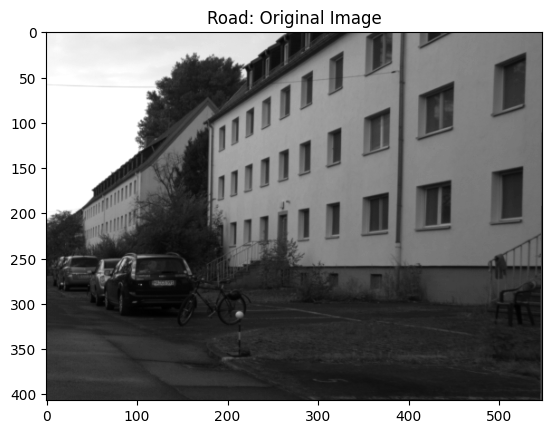

In [3]:
plt.title("Road: Original Image")
plt.imshow(original_image, cmap="gray")
plt.show()

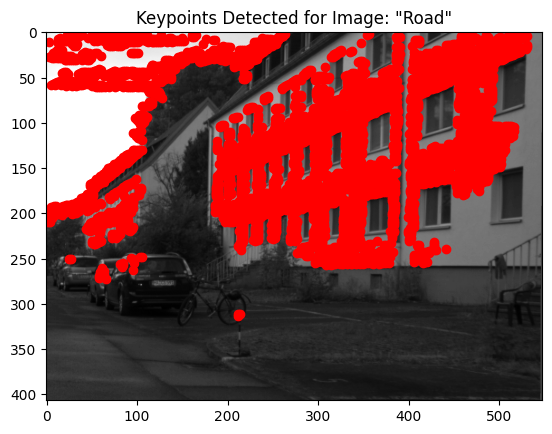

In [4]:
HessianDetector.find_keypoints_and_visualize(
    np.array(original_image), 
    "Road",
    percentile=68.05  # note: I had to run the code several times to arrive at this value
)

## Problem 2: RANSAC

### Core RANSAC Implementation Code

For convenience, let's make it so that we have a NumPy-ified version of the image on hand:

In [5]:
img_array = np.array(original_image)

Let's test out the core RANSAC algorithm implementation:

In [6]:
from util.model_fitting import RANSACDetector

In [7]:
np.random.seed(42)

In [8]:
# test
keypoints = HessianDetector().find_keypoints(
    img_array, percentile=68.05
)

assert keypoints.shape[0] == 2

In [9]:
ransac = RANSACDetector()

In [10]:
top_4_models, num_iterations = ransac.fit(
    keypoints
)

/Users/zainraza/Downloads/dev/courses/Stevens/CS-558/Line-Detection/util/model_fitting.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  m = (point2[0] - point1[0]) / (point2[1] - point1[1])
/Users/zainraza/Downloads/dev/courses/Stevens/CS-558/Line-Detection/util/model_fitting.py:64: RuntimeWarning: invalid value encountered in scalar add
  numerator = abs(a * x_coord + b * y_coord + c)


In [11]:
num_iterations

3590.120646659043

In [12]:
[
    top_4_models[row][0].shape
    for row in range(len(top_4_models))
]

[(200, 2), (175, 2), (165, 2), (146, 2)]

In [13]:
[
    top_4_models[row][0].shape
    for row in range(len(top_4_models))
]

[(200, 2), (175, 2), (165, 2), (146, 2)]

### Visualizing RANSAC Results

In [14]:
import functools

In [15]:
keypoint_detector = HessianDetector()

keypoint_detector_for_road = functools.partial(
    keypoint_detector.find_keypoints, percentile=68.05
)

=============== Booyah! I just ran RANSAC :) ===================
Inlier threshold distance: 3.0, so we can reach a confidence level of approx. 0.95.
Total number of iterations (rounded to the nearest integer): 1911.
Confidence Level used in Calculating No. of Iterations: 0.99.


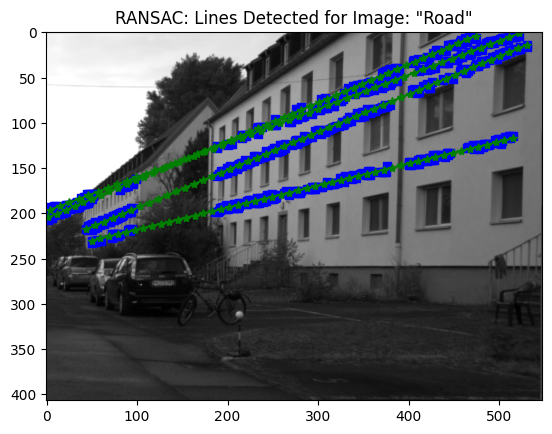

In [16]:
RANSACDetector.fit_and_report(
    image=img_array,
    keypoint_detector_algorithm=keypoint_detector_for_road,
    image_name='Road',
    distance_threshold=3.0,
)